<a href="https://colab.research.google.com/github/Venkata1345/mlproject/blob/main/Image_to_text_and_text_to_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))


GPU Available: True
GPU Name: Tesla T4


In [2]:
!pip install transformers datasets torchvision torch openai
!pip install opencv-python pillow tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip -d flickr30k/
!unzip Flickr8k_text.zip -d flickr30k/


Streaming output truncated to the last 5000 lines.
  inflating: flickr30k/__MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: flickr30k/Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: flickr30k/__MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: flickr30k/Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: flickr30k/__MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: flickr30k/Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: flickr30k/__MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: flickr30k/Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: flickr30k/__MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: flickr30k/Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: flickr30k/__MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: flickr30k/Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: flickr30k/__MACOSX/Flicker8k_Dataset/._343

In [2]:
import os

image_files = os.listdir("/content/flickr30k/Flicker8k_Dataset")
print("🖼️ First 5 images:", image_files[:5])


🖼️ First 5 images: ['407569668_19b3f8eaf6.jpg', '3650986674_3e101c606b.jpg', '3532028205_9ddd7599f8.jpg', '3474958471_9106beb07f.jpg', '1359101233_16c2c150e3.jpg']


In [17]:
import pandas as pd
import os
from PIL import Image
import torchvision.transforms as transforms

# Load captions
captions_file = "/content/flickr30k/Flickr8k.token.txt"
df = pd.read_csv(captions_file, delimiter="\t", names=["image", "caption"])

# Clean data (remove duplicate image names)
df["image"] = df["image"].apply(lambda x: x.split("#")[0])  # Remove caption index (e.g., image#0.jpg -> image.jpg)
df = df.groupby("image")["caption"].apply(list).reset_index()

# Function to display an image and captions
def display_sample(idx):
    image_name = df.iloc[idx]["image"]
    image_path = os.path.join("/content/flickr30k/Flicker8k_Dataset", image_name)
    image = Image.open(image_path)

    print(f"📸 Image: {image_name}")
    print("📝 Captions:")
    for i, caption in enumerate(df.iloc[idx]["caption"]):
        print(f"{i+1}. {caption}")

    image.show()

# Display a sample image and captions
display_sample(0)


📸 Image: 1000268201_693b08cb0e.jpg
📝 Captions:
1. A child in a pink dress is climbing up a set of stairs in an entry way .
2. A girl going into a wooden building .
3. A little girl climbing into a wooden playhouse .
4. A little girl climbing the stairs to her playhouse .
5. A little girl in a pink dress going into a wooden cabin .


In [18]:
# converting images into embeddings
from transformers import ViTFeatureExtractor, ViTModel
import torch

# Load ViT Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to("cuda")

# Transform Image for ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Function to extract image features
# Update the function to load images properly
def extract_image_features(image_path):
    from PIL import Image
    image = Image.open(image_path).convert("RGB")  # Ensure RGB format
    image = transform(image).unsqueeze(0).to("cuda")  # Add batch dimension
    with torch.no_grad():
        features = vit_model(image).last_hidden_state[:, 0, :]  # Extract features
    return features.cpu()

# Extract features from a sample image
sample_image_path = os.path.join("/content/flickr30k/Flicker8k_Dataset", df.iloc[0]["image"])
image_features = extract_image_features(sample_image_path)
print("🔢 Image Feature Shape:", image_features.shape)  # Expected output: (1, 768)


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


🔢 Image Feature Shape: torch.Size([1, 768])


In [19]:
# convert captions to tokens for GPT-2
from transformers import GPT2Tokenizer

# Load GPT-2 Tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add a padding token
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token # or '[PAD]'

# Function to tokenize captions
def tokenize_caption(caption):
    tokens = gpt2_tokenizer(caption, return_tensors="pt", padding="max_length", truncation=True, max_length=30)
    return tokens.input_ids, tokens.attention_mask

# Example: Tokenize a caption
sample_caption = df.iloc[0]["caption"][0]
input_ids, attention_mask = tokenize_caption(sample_caption)

print("📝 Sample Caption:", sample_caption)
print("🔢 Tokenized:", input_ids.shape)  # Expected output: (1, 30)

📝 Sample Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
🔢 Tokenized: torch.Size([1, 30])


In [20]:
from transformers import GPT2LMHeadModel,GPT2Config
import torch.nn as nn

# Load GPT-2 configuration and enable cross-attention
config = GPT2Config.from_pretrained("gpt2")
config.add_cross_attention = True

# Load GPT-2 model
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2",config=config).to("cuda")

# Custom Model: ViT + GPT-2
class ImageCaptioningModel(nn.Module):
    def __init__(self, vit, gpt2):
        super(ImageCaptioningModel, self).__init__()
        self.vit = vit
        self.gpt2 = gpt2
        self.linear = nn.Linear(768, 768)  # Map ViT output to GPT-2 embedding size

    def forward(self, images, captions):
        image_features = self.vit(images).last_hidden_state[:, 0, :]
        image_features = self.linear(image_features)
        outputs = self.gpt2(input_ids=captions, encoder_hidden_states=image_features.unsqueeze(1),use_cache=False)
        return outputs.logits

# Initialize Model
model = ImageCaptioningModel(vit_model, gpt2_model).to("cuda")


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

In [50]:
torch.cuda.empty_cache()


In [48]:
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Custom Dataset Loader
class FlickrDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        # Filter out rows with missing images
        self.dataframe = self.dataframe[self.dataframe["image"].apply(lambda x: os.path.exists(os.path.join("/content/flickr30k/Flicker8k_Dataset", x)))]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load image and extract features
        image_name = self.dataframe.iloc[idx]["image"]
        # Check if the image name ends with '.1' and remove it if necessary
        if image_name.endswith(".1"):
            image_name = image_name[:-2]  # Remove the last two characters ('.1')

        # ✅ Image file existence is already checked in __init__
        image_path = os.path.join("/content/flickr30k/Flicker8k_Dataset", image_name)

        image = Image.open(image_path).convert("RGB")
        image = transform(image)

        # Select one caption and tokenize
        caption = self.dataframe.iloc[idx]["caption"][0]
        caption_tokens, _ = tokenize_caption(caption)

        return image, caption_tokens.squeeze(0)  # Remove extra dimension

# DataLoader
dataset = FlickrDataset(df[:3000])  # Train on 5000 samples
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Training Loop
# ... (rest of your training loop code)

# DataLoader
dataset = FlickrDataset(df[:5000])  # Train on 5000 samples
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Training Loop
optimizer = Adam(model.parameters(), lr=5e-5)
accumulation_steps = 2  # Update every 2 mini-batches

for epoch in range(10):
    optimizer.zero_grad()
    for i, (images, captions) in enumerate(dataloader):
        # ✅ Check if data is None (due to missing image)
        if images is None or captions is None:
            continue  # Skip this iteration

        images, captions = images.to("cuda"), captions.to("cuda")
        logits = model(images, captions)
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), captions.view(-1))
        loss = loss / accumulation_steps  # Normalize loss
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 6.910023785167141e-06
Epoch 2, Loss: 3.891231301622611e-07
Epoch 3, Loss: 8.513709985891182e-07
Epoch 4, Loss: 1.8392243816833798e-07
Epoch 5, Loss: 1.345358811022379e-07
Epoch 6, Loss: 1.840222125792934e-06
Epoch 7, Loss: 1.3907730078699387e-07
Epoch 8, Loss: 2.5714950879773824e-07
Epoch 9, Loss: 2.0293882130317797e-07
Epoch 10, Loss: 2.713402409426635e-07


In [49]:
import torch

def top_k_top_p_filtering(logits, top_k=50, top_p=0.95, filter_value=-float("Inf")):
    """Applies top-k and top-p filtering to logits to improve text generation quality."""
    if top_k > 0:
        top_k = min(max(top_k, 1), logits.size(-1))  # Ensure valid top_k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(torch.nn.functional.softmax(sorted_logits, dim=-1), dim=-1)

        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = False

        for i in range(logits.shape[0]):
            logits[i][sorted_indices[i][sorted_indices_to_remove[i]]] = filter_value

    return logits


In [50]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

def generate_caption(image_path, model, vit_model, tokenizer, max_length=30):
    model.eval()

    # ✅ Step 1: Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to("cuda")

    # ✅ Step 2: Extract image features using ViT
    with torch.no_grad():
        image_features = vit_model(image).last_hidden_state[:, 0, :]
        image_features = model.linear(image_features)

    # ✅ Step 3: Start with <BOS> token
    input_ids = torch.tensor([[tokenizer.bos_token_id]]).to("cuda")
    caption = []

    for _ in range(max_length):
        outputs = gpt2_model(input_ids=input_ids, encoder_hidden_states=image_features.unsqueeze(1))

        logits = outputs.logits[:, -1, :]

        # ✅ Apply custom top-k, top-p filtering
        filtered_logits = top_k_top_p_filtering(logits, top_k=50, top_p=0.95)
        probabilities = torch.nn.functional.softmax(filtered_logits / 1.2, dim=-1)  # ✅ Use temperature = 1.2
        next_token = torch.multinomial(probabilities, num_samples=1)

        input_ids = torch.cat([input_ids, next_token], dim=-1)

        if next_token.item() == tokenizer.eos_token_id:
            break

        caption.append(next_token.item())

    # ✅ Convert tokenized output to text
    caption_text = tokenizer.decode(caption, skip_special_tokens=True)

    # ✅ Display the image with the generated caption
    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"📝 Generated Caption: {caption_text}")
    plt.show()

    return caption_text


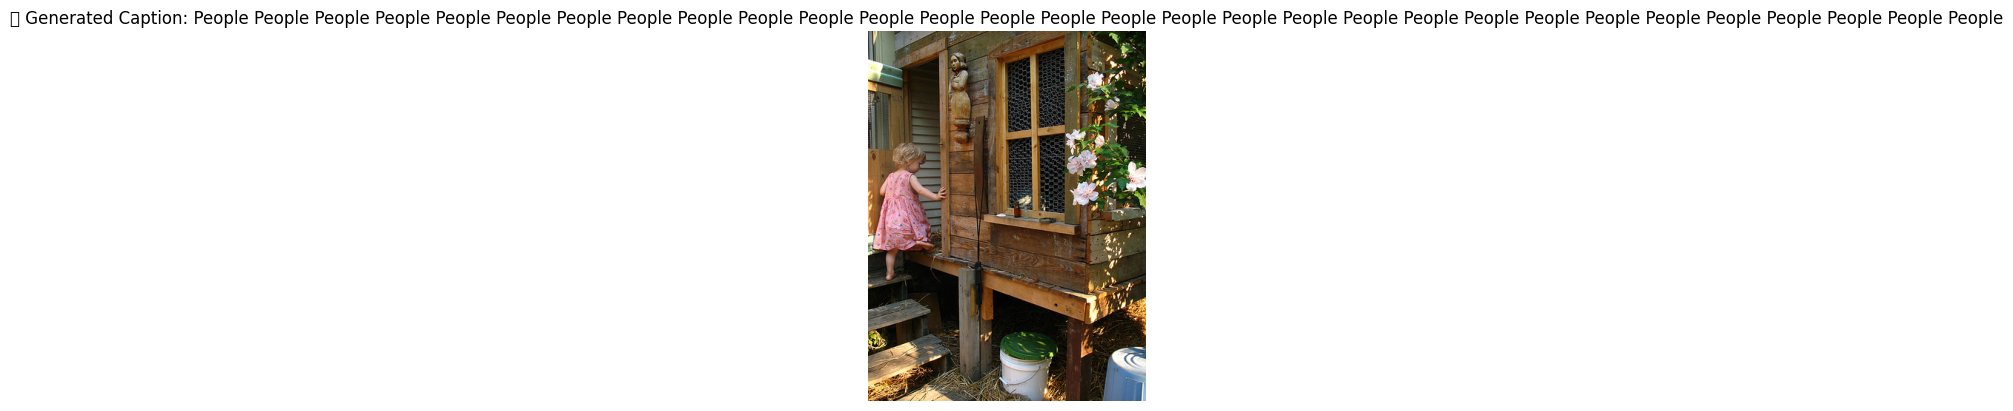

📝 Generated Caption: People People People People People People People People People People People People People People People People People People People People People People People People People People People People People People


In [51]:
# Test the model on a new image
test_image_path = "/content/flickr30k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg"  # Change this to your image
caption = generate_caption(test_image_path, model, vit_model, gpt2_tokenizer)

print("📝 Generated Caption:", caption)


In [42]:
# Pick a random training sample and see if captions make sense
for i in range(5):
    print(f"📝 Sample Caption {i+1}:", df.iloc[i]["caption"][0])


📝 Sample Caption 1: A child in a pink dress is climbing up a set of stairs in an entry way .
📝 Sample Caption 2: A black dog and a spotted dog are fighting
📝 Sample Caption 3: A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
📝 Sample Caption 4: A man lays on a bench while his dog sits by him .
📝 Sample Caption 5: A man in an orange hat starring at something .
